# Training of the models with the Real Dataset

In this notebook we show the training and the parameters used for the models. The data used is the *real dataset*, uses weather data from LA.

In [1]:
#!pip install timesynth
# TIMESYNTH TO GENERATE TIME SERIESES
import ts_syntheticData
from ts_syntheticData import insert_anomalies
# CUSTOM DEFINED DATALOADERS AND MODELS
from ts_dataloader import get_datasets, load_data
from ts_training import train_network
from ts_VI_LSTM import Variational_LSTM, loss_normal2d, loss_normal2d_lognormal
from ts_simple_LSTM_net import Standard_LSTM, loss_function_normal
from ts_anomaly_function import detect_anomalies, detect_anomalies_VAE
# PYTORCH
import torch
from torch import optim, distributions
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
# MATPLOTLIB NUMPY
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
import math

In [2]:
def plot_anomalies(anomaly_data, sequence, A=0, B=1000):

    labels = anomaly_data["outlier_label"]
    if sequence.shape[0] != len(labels):
        raise ValueError("The length of the sequence and the number of labels whould be the same.")
    
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    figures= []
    for dimension in range(sequence.shape[1]):

        fig = plt.figure(figsize = (8,4))
        plt.title("Feature {}".format(dimension))
        for t in range(Ti, Tf-1):
            plt.plot(t, sequence[t, dimension], 'o', color="red" if labels[t] else "blue", markersize = 6 if labels[t] else 2)
        plt.plot(time_axis, sequence[Ti:Tf-1,dimension], label = "Real data")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        figures.append(fig)
        plt.show()
    
    return figures

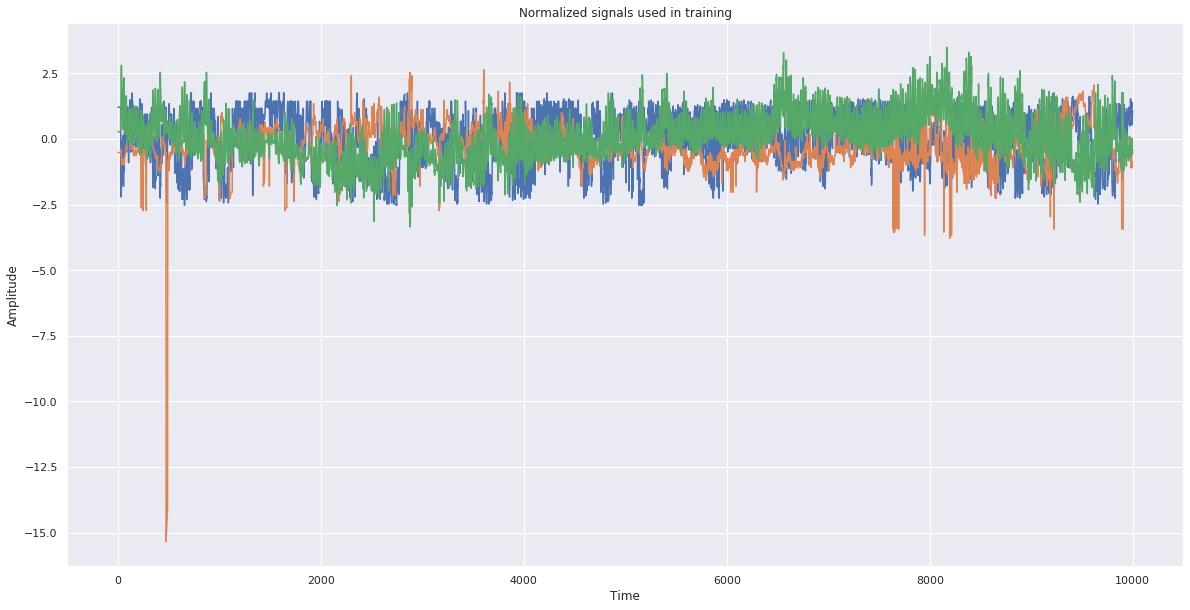

In [4]:
#USEDATASET = 0  # simple synthetic dataset
#USEDATASET = 1 # correlated synthetic dataset
USEDATASET = 2 # realistic weather dataset

# anomaly parameters
add_anomalies = False
if (USEDATASET == 0) or (USEDATASET == 1):
    add_anomalies = True
# anomaly probability
anomalies_p = 0.001
# anomaly magnitude
anomalies_m = 3


# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

# number of samples in the time series
train_T = 10000
valid_T = 5000
test_T = 5000
# width of the window of each time series
W = 10000
# check for inconsistency
if W > train_T:
    raise ValueError("The time window cannot be longer than the training data sequence available.")

T = train_T + valid_T + test_T
# the size of train and validation, test is the remainder of the data
t_v_t_split = [train_T/T,valid_T/T]

#load the data in, this is supposed to happen only once
raw_signals = load_data(USEDATASET, T)

if add_anomalies:
    timeseries_signals, timeseries_labels = insert_anomalies(raw_signals, magnitude=anomalies_m, p=anomalies_p)
else:
    timeseries_signals = raw_signals
    timeseries_labels = None

features, train_dataset, valid_dataset, test_dataset = get_datasets(USEDATASET, t_v_t_split, W, device, timeseries_signals, timeseries_labels)

train_timeseries_signals = train_dataset.get_data()[0]
plt.figure(figsize = (20,10))
plt.title("Normalized signals used in training")
plt.plot(list(range(len(train_timeseries_signals))), train_timeseries_signals)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [6]:
# Here we can change to batch size
# batch size (number of serieses of length W)
B = 1
# check for consistency, we don't want to pad the sequence if possible
if (train_T - W + 1) % B != 0 :
    raise ValueError("The batch size chosen will result in different sized batches during training")

# create the Synthetic Dataset
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=False)
#valid_loader = DataLoader(valid_dataset, shuffle=False)
#seq_loader = DataLoader(valid_dataset, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Baseline LSTM model

Here we use the baseline LSTM. Because of the dropout, which alleviates greatly overfitting, the size of the network is quite big. We use a straightforward LSTM followed by a dropout and a linear layer to map to the correct number of parameters for the output distribution.

In [ ]:
class Standard_LSTM(nn.Module):
    def __init__(self, input_dimension, param_size, hidden_dim):
        super(Standard_LSTM, self).__init__()

        # parameters
        self.input_dimension = input_dimension
        self.hidden_dim = hidden_dim
        self.param_size = param_size

        # activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

        # model
        self.lstm = nn.LSTM(input_dimension, hidden_dim, num_layers=2)
        self.hidden2hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2params = nn.Linear(hidden_dim, param_size * input_dimension)

    def forward(self, x, device):
        outputs = {}
        outputs["x_input"] = x
        x = x.permute(1, 0, 2)
        # lstm_out is the output of the last layer of hidden units [seq_len, batch, num_directions * hidden_size]
        # h is the hidden states at the last time step
        # c is the cell state at the last time step
        lstm_out, (h, c) = self.lstm(x)
        linear_in = self.dropout(self.relu(lstm_out))

        # take output of hidden layers at each time step h_t and run it through a fully connected layer
        params = self.hidden2params(linear_in)

        outputs["params"] = params
        outputs["param_size"] = self.param_size
        return outputs


def loss_function_normal(model_output, device):
    # unpack the required quantities
    x_true = model_output["x_input"].permute(1, 0, 2)

    input_dimension = x_true.shape[2]

    # check to see if something went wrong with selecting the right loss function and network pair
    if model_output["params"].shape[2] != 2 * input_dimension:
        raise ValueError("Wrong input dimensions or number of parameters in the output")

    # extrapolate parameters
    mu, log_var = torch.chunk(model_output["params"], 2, dim=2)
    sigma = torch.exp(log_var / 2)
    
    
    #get the length of the sequence
    seq_length = mu.shape[0]
    # iterate over each time step in the sequence to compute NLL
    t = 0
    # define the distribution
    p = distributions.Normal(mu[t, :, :], sigma[t, :, :])
    log_prob = torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)

    for t in range(1, seq_length - 1):
        # define the distribution
        p = distributions.Normal(mu[t, :, :], sigma[t, :, :])

        log_prob += torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)

    NLL = - torch.mean(log_prob, dim=0) / seq_length
    return {
        "loss": NLL,
        "NLL": NLL
    }


Training has started.


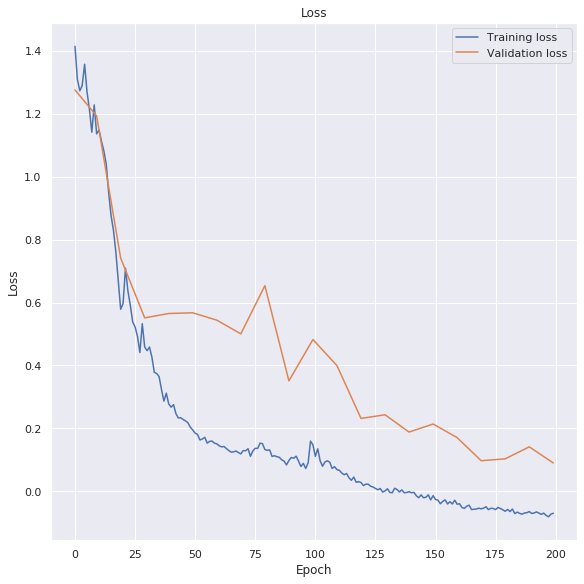

In [24]:
epochs_LSTM = 200
params_distribution = 2
hidden_layer_size = 64
torch.manual_seed(42)
np.random.seed(42)

#define the network
net = Standard_LSTM(features, params_distribution, hidden_layer_size)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_function_normal
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.05, weight_decay = 1e-3)
#here we define the scheduler
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

#run the training
net_state_dict, train_fig = train_network(device, train_loader, valid_dataset , epochs_LSTM, net, loss_function,\
                                          optimizer, scheduler = scheduler, plotting = False)
net_state_dict_LSTM = net_state_dict
train_fig_LSTM = train_fig
plt.show()

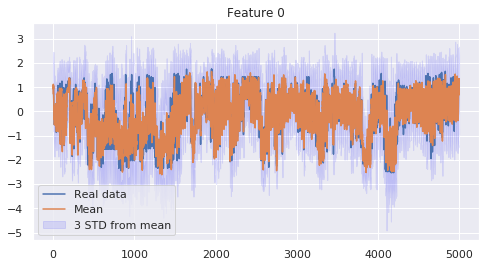

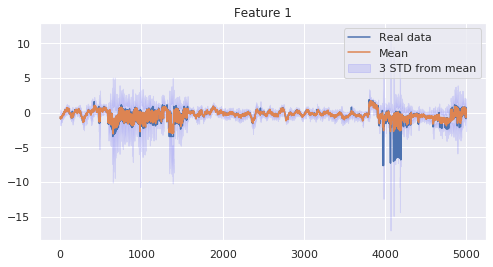

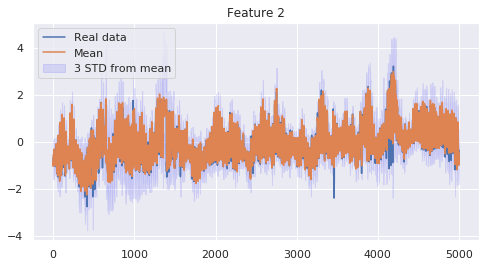

In [25]:
# start time of plotting
A = 0
# end time of plotting
B = 25000
# select the sequence to test the network on
sequence = test_dataset.get_data()[0]
sequence = train_dataset.get_data()[0]
sequence = valid_dataset.get_data()[0]

with torch.no_grad():
    # redifine the network
    net = Standard_LSTM(features, params_distribution, hidden_layer_size)
    # push it to the correct device
    net.to(device)
    # load the state of the trained network
    net.load_state_dict(net_state_dict_LSTM)   
    
    # get it to the device and  put the batch dimension
    prepared_sequence = (sequence).to(device).unsqueeze(0)
    
    # run the model
    output_model = net(prepared_sequence, device)

    # extract the parameters at each time step
    mu, logvar = torch.chunk(output_model["params"], 2, dim=-1)
    std_dev = torch.exp(logvar/2)

    # PLOTTING
    # extract start and end points
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    output_model_figs_LSTM = []
    
    for dimension in range(sequence.shape[1]):
        mean = torch.mean(mu, dim = 1)[Ti:Tf-1,dimension].cpu()
        std = 3*torch.mean(std_dev, dim = 1)[Ti:Tf-1,dimension].cpu()

        fig = plt.figure(figsize = (8,4))
        plt.title("Feature {}".format(dimension))
        plt.plot(time_axis, sequence[Ti+1:Tf,dimension], label = "Real data")
        plt.plot(time_axis, mean, label="Mean")
        plt.fill_between(time_axis, mean - std, mean + std,
                 color='blue', alpha=0.1, label="3 STD from mean")
        plt.legend()
        output_model_figs_LSTM.append(fig)
        plt.show()


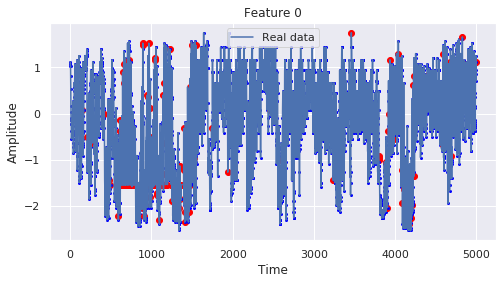

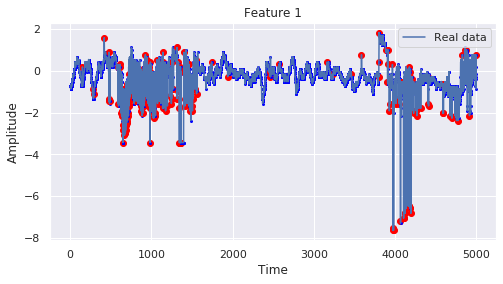

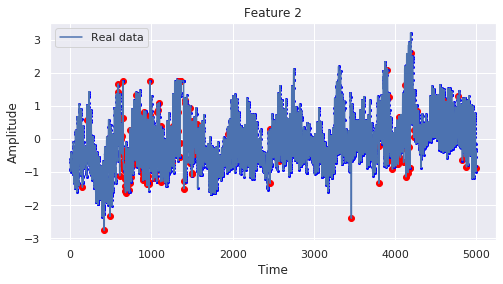

In [26]:
# redifine the network
net = Standard_LSTM(features, params_distribution, hidden_layer_size)
# push it to the correct device
net.to(device)
# load the state of the trained network
net.load_state_dict(net_state_dict_LSTM)

sequence = valid_dataset.get_data()[0]
#sequence = test_dataset.get_data()[0]

percentage = 0.5
anomaly_data = detect_anomalies(sequence, net, device, percentage/100, False)
anomalies_figs_LSTM = plot_anomalies(anomaly_data, sequence, 0, 25000)

In [27]:
if not valid_dataset.has_labels():
    accuracy_LSTM = {
        # number of labels correctly predicted
        "correct": 0,  
        # false positives (the datapoint was not an anomaly but it was predicted as one)
        "false_positives": 0,
        # false negatives (the datapoint was an anomaly abut it was not predicted as one)
        "false_negatives": 0,
        # total number of datapoints in the sequence
        "total": 0,
        # total number of anomalies
        "anomaly_count": 0
    }
else:
    predictions = anomaly_data["outlier_label"]
    ground_truth = valid_dataset.get_data()[1]
    #ground_truth = test_dataset.get_data()[1]
    correct = 0
    total = len(predictions) - 1
    false_positives = 0
    false_negatives = 0
    anomaly_count = 0
    for i in range(total):
        if ground_truth[i] == True:
            anomaly_count += 1
        if predictions[i] == ground_truth[i]:
            correct += 1
        elif predictions[i] == False:
            false_negatives += 1
        elif predictions[i] == True:
            false_positives += 1
    accuracy_LSTM = {
        # number of labels correctly predicted
        "correct": correct,  
        # false positives (the datapoint was not an anomaly but it was predicted as one)
        "false_positives": false_positives,
        # false negatives (the datapoint was an anomaly abut it was not predicted as one)
        "false_negatives": false_negatives,
        # total number of datapoints in the sequence
        "total": total,
        # total number of anomalies
        "anomaly_count": anomaly_count
    }
print(accuracy_LSTM)

{'correct': 0, 'false_positives': 0, 'false_negatives': 0, 'total': 0, 'anomaly_count': 0}


# VI approach

Variational Inference approach. Uses the same structure of the Baseline LSTM. The first time it's used to get the parameters of the distirbution of the latent variables, the second time for the distribution of the next time-step.

In [ ]:
"""
Time Series Variational Inference LSTM

@author: Samuele Papa, Henrik Hviid Hansen
"""
import torch
from torch import nn, distributions

#Variational LSTM
# the VI LSTM approach.
class Variational_LSTM(nn.Module):
    def __init__(self, input_dim, param_dist, hidden_dim_rec, hidden_dim_gen, latent_dim):
        super(Variational_LSTM, self).__init__()

        # parameters
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim_rec = hidden_dim_rec
        self.hidden_dim_gen = hidden_dim_gen

        # activation and dropouts
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)

        # encoder net, recognition model q(z_t+1|x_1:t)
        self.encoder_LSTM = nn.LSTM(input_size=input_dim,
                                    hidden_size=hidden_dim_rec,  # 2 because we want mu and sigma
                                    num_layers=1
                                    )
        self.encoder_hidden2hidden = nn.Linear(hidden_dim_rec, hidden_dim_rec)

        self.enc2latent = nn.Linear(hidden_dim_rec, 2 * latent_dim)

        # decoder net p(x_t+1|x_1:t,z_1:t)
        self.decoder_LSTM = nn.LSTM(input_size=input_dim + latent_dim,
                                    hidden_size=hidden_dim_gen,
                                    num_layers=1
                                    )

        self.decoder_hidden2hidden = nn.Linear(hidden_dim_gen, hidden_dim_gen)

        self.dec2features = nn.Linear(hidden_dim_gen, param_dist * input_dim)

    def forward(self, x, device):
        outputs = {}
        outputs["x_input"] = x
        batch_size = x.shape[0]
        seq_length = x.shape[1]
        # --- recognition LSTM to generate latent variable(s) for each time step --- #

        # get x in the right format: [seq_length, batch_size, input_dimension]
        x_encoder = x.permute(1, 0, 2)
        encoder_out, (h, c) = self.encoder_LSTM(x_encoder)
        # add non-linearities and a level of abstraction
        # outputs the latent variable parameters mu and sigma
        x_latent = self.enc2latent(self.dropout1(self.relu(encoder_out)))

        # make the network learn the log of the variance it is non-negative (log only takes pos x)
        mu, log_var = torch.chunk(x_latent, 2, dim=-1)
        sigma = torch.exp(log_var / 2)  # std of the latent variable distribution
        # reparameterization trick happens here:
        epsilon = 0
        with torch.no_grad():
            epsilon = torch.randn(seq_length,
                                  batch_size,
                                  self.latent_dim,
                                  ).to(device)
        # create the random latent variable, reparametrization trick
        z = mu + sigma * epsilon

        # store intermediate results and latent variables
        outputs["z"] = z
        outputs["z_mu"] = mu
        outputs["z_sigma"] = sigma
        outputs["z_log_var"] = log_var

        # --- ordinary LSTM to predict the next x in the time sequence --- #
        # concatenate the latent variables with the original input x
        # [sequence_len, batch_size, dimensions]
        x_aug = torch.cat((x_encoder, z), dim=-1)  # aug = augmented x, because we augment x with z

        # run it through the ordinary LSTM
        decoder_out, (h, c) = self.decoder_LSTM(x_aug)
        # decoder_out = self.relu(self.decoder_hidden2hidden(decoder_out))
        # decoder_out = self.relu(decoder_out)

        # symmetry with encoder
        # [sequence_len, batch_size, dimensions]
        params = self.dec2features(self.dropout2((self.relu(decoder_out))))

        # store the outputs in the form (batch_size, seq_length, input_dim)
        outputs["params"] = params

        return outputs

# loss function used for Gaussian normal distribution of the signals
# arguments:
#   - model_output: the output of the model
#   - device: where to place the data
def loss_normal2d(model_output, device, beta):
    # unpack the required quantities
    x_true = model_output["x_input"].permute(1, 0, 2)
    params = model_output["params"]
    mu, logvar = torch.chunk(params, 2, dim=-1)
    sigma = torch.exp(logvar / 2)

    z_mu = model_output["z_mu"]
    z_log_var = model_output["z_log_var"]

    seq_length = mu.shape[0]

    t = 0
    # define the distribution
    p = distributions.Normal(mu[t, :, :], sigma[t, :, :])
    log_prob = torch.sum(p.log_prob(x_true[t + 1, :, :]), dim=-1)
    # dimensions [batch_size, dimension]
    ones_vector = torch.ones((z_mu.shape[1], z_mu.shape[2])).to(device)
    # KL-divergence
    negative_kl = 0.5 * torch.sum(ones_vector + z_log_var[t, :, :] - z_mu[t, :, :] ** 2 - torch.exp(z_log_var[t, :, :]),
                                  dim=-1)
    # KL divergence through time
    kl_tt = -negative_kl

    # iterate over each time step in the sequence to compute NLL and KL terms
    for t in range(1, seq_length - 1):
        # define the distribution
        p = distributions.Normal(mu[t, :, :], sigma[t, :, :])

        log_prob += torch.sum(p.log_prob(x_true[t + 1, :, :]), dim=-1)
        # KL-divergence
        negative_kl += 0.5 * torch.sum(ones_vector + z_log_var[t, :, :] - z_mu[t, :, :] ** 2 -
                                       torch.exp(z_log_var[t, :, :]), dim=-1)

        kl_tt -= negative_kl
    # average over the batches and divide by the sequence len-1 to get size independent from the length of the sequence
    NLL, KL = -torch.mean(log_prob, dim=0) / (seq_length - 1), torch.mean(kl_tt, dim=0) / (seq_length - 1)

    ELBO = NLL + beta * KL

    return {
        "loss": ELBO,
        "ELBO": ELBO,
        "NLL": NLL,
        "KL": KL
    }

Training has started.


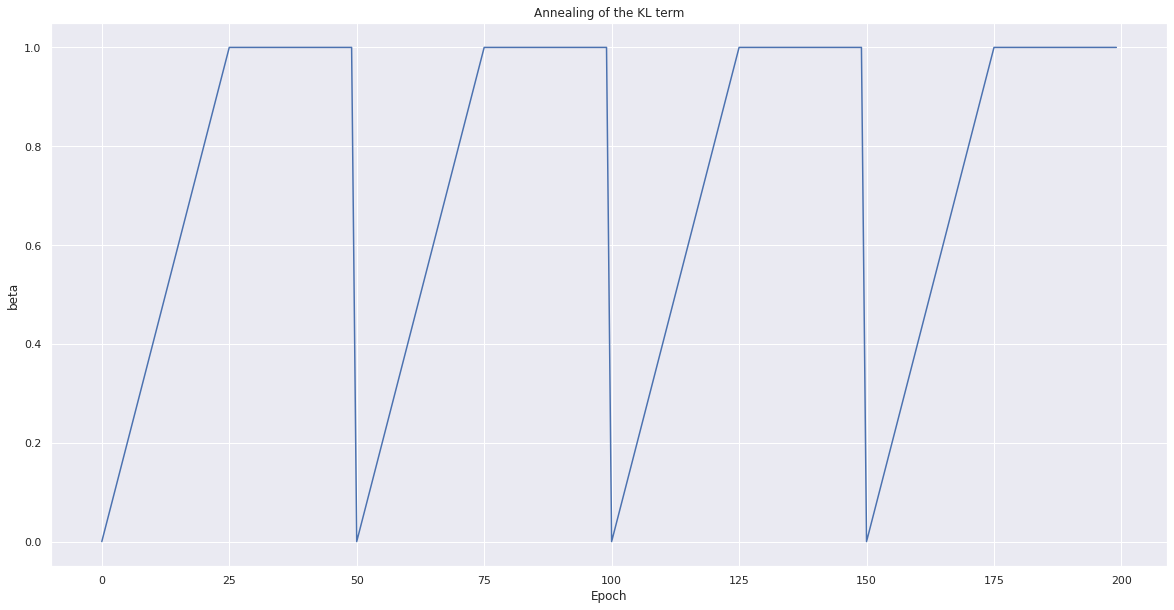

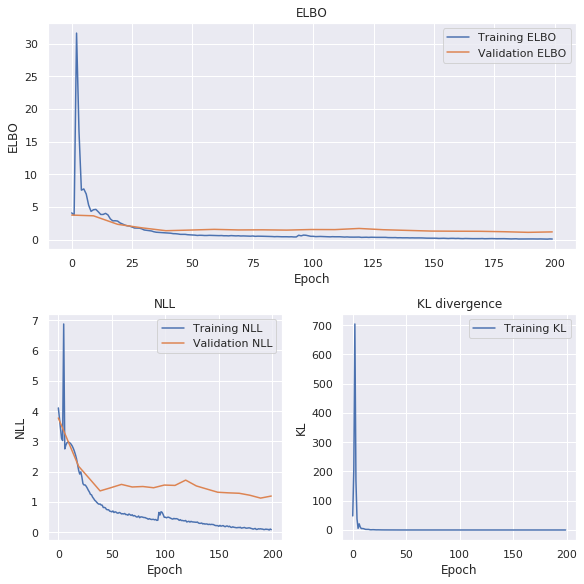

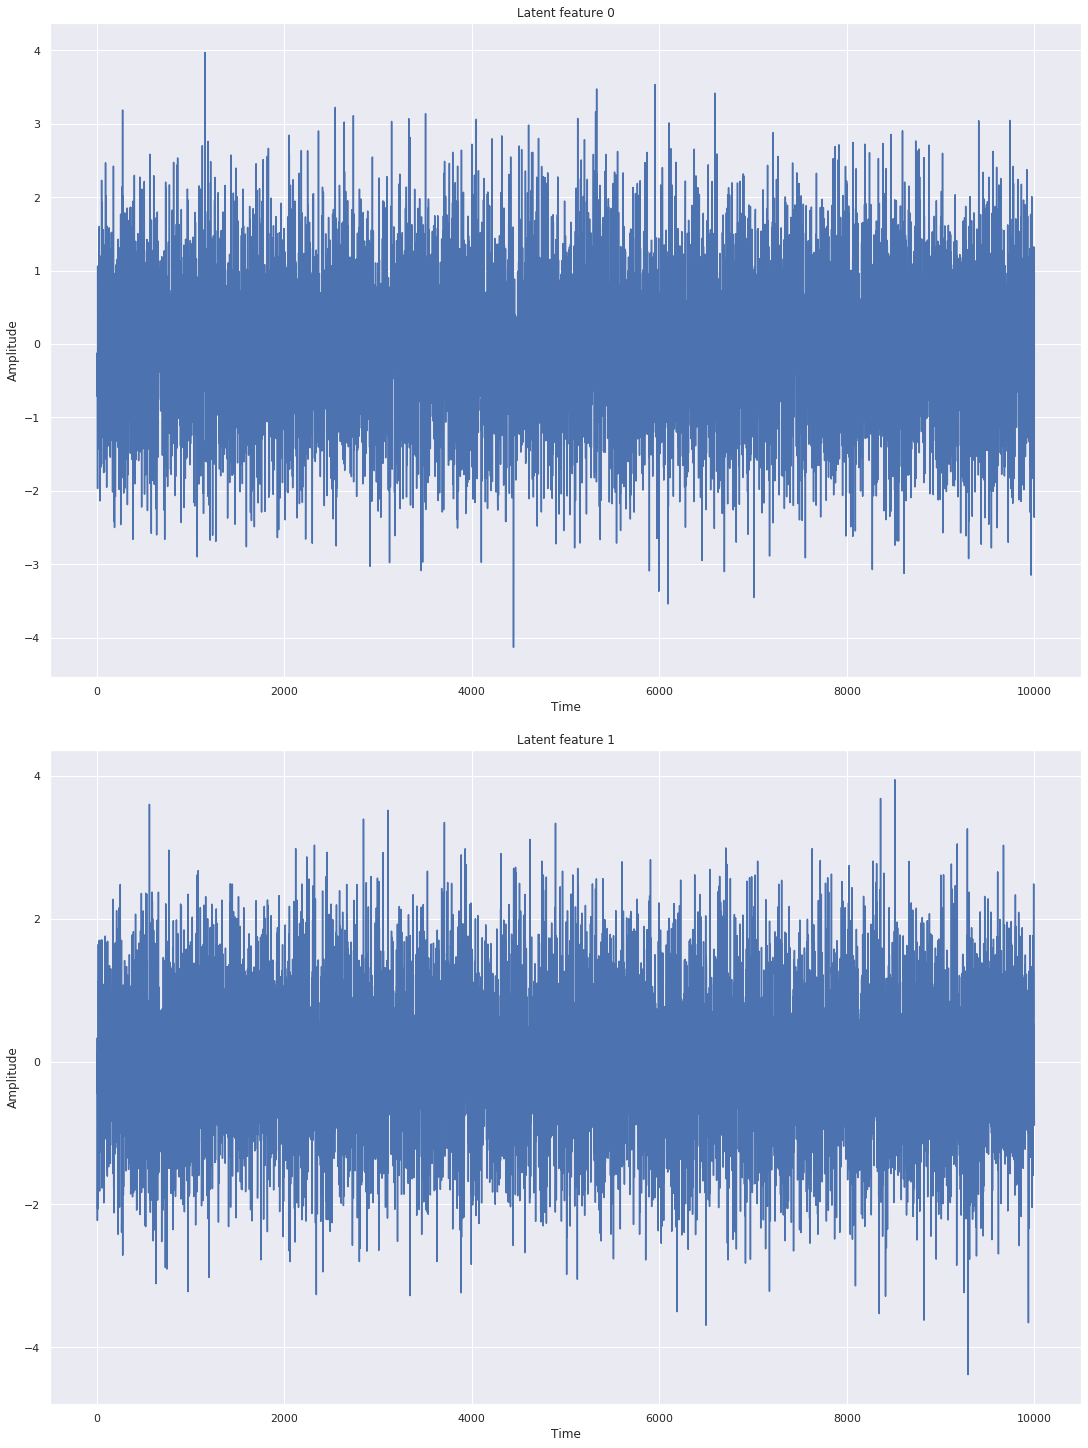

In [8]:
epochs_VAE = 200
params_distribution = 2
hidden_dim_gen = 128
hidden_dim_rec = 128
latent_dim = 2
torch.manual_seed(42)
np.random.seed(42)

#define the network
net = Variational_LSTM(features, params_distribution, hidden_dim_rec, hidden_dim_gen, latent_dim)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_normal2d
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 1e-4)
#here we define the scheduler
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# beta annealing to try to address the vanishing KL
def constant_schedule(beta, epoch):
    return 0
def monotonic_sigmoid_schedule(beta, epoch):
    k = 1.4 # steepness
    m = 40 # half time
    return (k**(epoch-m))/((k**(epoch-m))+1)
def monotonic_linear_schedule(beta, epoch):
    start_epoch = 0
    len_annealing = 100
    if epoch < start_epoch:
        return 0
    elif epoch < start_epoch + len_annealing:
        return min(beta + 1./len_annealing,1.)
    else:
        return 1
def monotonic_weighted_linear_schedule(beta, epoch):
    start_epoch = 50
    len_annealing = 50
    maximum_beta = 0.0001
    if epoch < start_epoch:
        return 0
    elif epoch < start_epoch + len_annealing:
        return min(beta + maximum_beta/len_annealing,maximum_beta)
    else:
        return maximum_beta
def cyclic_annealing_schedule(beta, epoch):
    M = 4
    L = epochs_VAE / M
    R = 0.5
    tau = (epoch % math.ceil(L))/L
    f_type = "linear" #linear, sigmoid
    if tau <= R:
        return increasing_function(tau, f_type, R)
    else:
        return 1
def increasing_function(tau, f_type, R):
    if f_type == "linear":
        return tau/R
    elif f_type == "sigmoid":
        k = 1.04 # steepness
        m = R/2 # half time
        return (k**(1000*(tau-m)))/((k**(1000*((tau-m))))+1)

chosen_annealing = cyclic_annealing_schedule

betas = []
beta = 0
for epoch in range(epochs_VAE):
    betas.append(chosen_annealing(beta, epoch))
    beta = betas[-1]
plt.figure(figsize = (20,10))
plt.title("Annealing of the KL term")
plt.xlabel("Epoch")
plt.ylabel("beta")
plt.plot(list(range(len(betas))), betas)


#run the training
net_state_dict, train_fig = train_network(device, train_loader, valid_dataset, epochs_VAE, net, \
                                          loss_function, optimizer, chosen_annealing, scheduler = scheduler, \
                                          p_anomaly = 1e-5, plotting = False)
net_state_dict_VAE = net_state_dict
train_fig_VAE = train_fig

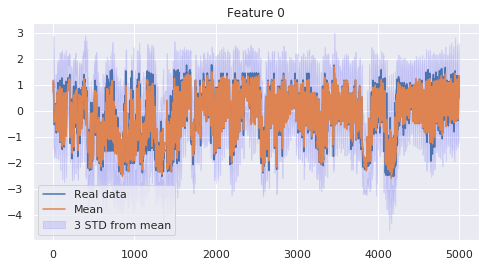

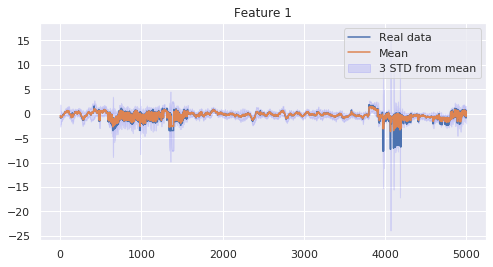

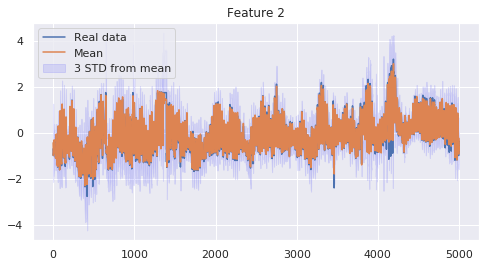

In [10]:
# start time of plotting
A = 0
# end time of plotting
B = 25000
# select the sequence to test the network on
sequence =  test_dataset.get_data()[0]
sequence = train_dataset.get_data()[0]
sequence = valid_dataset.get_data()[0]

with torch.no_grad():
    # redefine the network
    net = Variational_LSTM(features, params_distribution, hidden_dim_rec, hidden_dim_gen, latent_dim)
    #push it to the correct device
    net.to(device)
    # load the state of the trained network
    net.load_state_dict(net_state_dict_VAE)    
    
    net.eval()
    
    # get it to the device and  put the batch dimension
    prepared_sequence = (sequence).to(device).unsqueeze(0)
    
    # run the model
    output_model = net(prepared_sequence, device)

    # extract the parameters at each time step
    mu, logvar = torch.chunk(output_model["params"], 2, dim=-1)
    std_dev = torch.exp(logvar/2)
    #rate = torch.exp(output_model["params"])
    #mu = 1/rate
    #std_dev = mu
    

    # PLOTTING
    # extract start and end points
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    output_model_figs_VAE = []
    
    for dimension in range(sequence.shape[1]):
        mean = torch.mean(mu, dim = 1)[Ti:Tf-1,dimension].cpu()
        std = 3*torch.mean(std_dev, dim = 1)[Ti:Tf-1,dimension].cpu()

        fig = plt.figure(figsize = (8,4))
        plt.title("Feature {}".format(dimension))
        plt.plot(time_axis, sequence[Ti+1:Tf,dimension], label = "Real data")
        plt.plot(time_axis, mean, label="Mean")
        plt.fill_between(time_axis, mean - std, mean + std,
                 color='blue', alpha=0.1, label="3 STD from mean")
        plt.legend()
        output_model_figs_VAE.append(fig)
        plt.show()


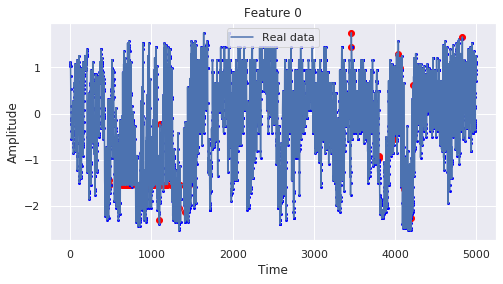

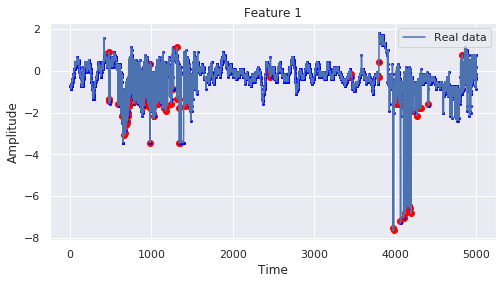

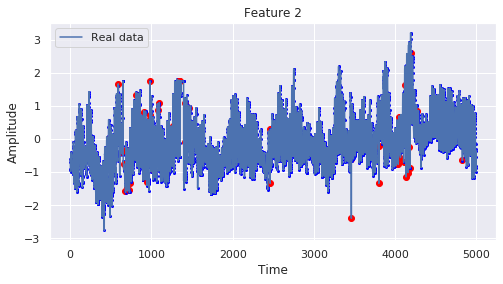

In [11]:
# redefine the network
net = Variational_LSTM(features, params_distribution, hidden_dim_rec, hidden_dim_gen, latent_dim)
#push it to the correct device
net.to(device)
# load the state of the trained network
net.load_state_dict(net_state_dict_VAE)

sequence = valid_dataset.get_data()[0]
#sequence = test_dataset.get_data()[0]

percentage = 0.000001
anomaly_data = detect_anomalies_VAE(sequence, net, device, percentage/100)
anomalies_figs_VAE = plot_anomalies(anomaly_data, sequence, 0, 25000)

In [12]:
if not valid_dataset.has_labels():
    accuracy_VAE = {
        # number of labels correctly predicted
        "correct": 0,  
        # false positives (the datapoint was not an anomaly but it was predicted as one)
        "false_positives": 0,
        # false negatives (the datapoint was an anomaly abut it was not predicted as one)
        "false_negatives": 0,
        # total number of datapoints in the sequence
        "total": 0,
        # total number of anomalies
        "anomaly_count": 0
    }
else:
    predictions = anomaly_data["outlier_label"]
    ground_truth = valid_dataset.get_data()[1]
    #ground_truth = test_dataset.get_data()[1]
    correct = 0
    total = len(predictions) - 1
    false_positives = 0
    false_negatives = 0
    anomaly_count = 0
    for i in range(total):
        if ground_truth[i] == True:
            anomaly_count += 1
        if predictions[i] == ground_truth[i]:
            correct += 1
        elif predictions[i] == False:
            false_negatives += 1
        elif predictions[i] == True:
            false_positives += 1
    accuracy_VAE = {
        # number of labels correctly predicted
        "correct": correct,  
        # false positives (the datapoint was not an anomaly but it was predicted as one)
        "false_positives": false_positives,
        # false negatives (the datapoint was an anomaly abut it was not predicted as one)
        "false_negatives": false_negatives,
        # total number of datapoints in the sequence
        "total": total,
        # total number of anomalies
        "anomaly_count": anomaly_count
    }
print(accuracy_VAE)

{'correct': 0, 'false_positives': 0, 'false_negatives': 0, 'total': 0, 'anomaly_count': 0}
